In [2]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys #to send the return key easier
from selenium.webdriver.common.by import By
import time
import sys

In [3]:
class jobs:
    #default searching list
    search_list={'Python': ['python'], 'R': ['r'], 'Tableau': ['tableau'], 
                'SQL': ['sql', 'mysql'], 'Excel': ['excel'], 'Power BI': ['power bi', 'powerbi'], 
                'Sas': ['sas'], 'Power Point': ['power point', 'powerpoint'],
                'Python libraries': ['pandas', 'numpy', 'matplotlib']}
    max_errors = 5 #number of consecutive the program restarts if there is an error
    
    def __init__(self, job_name, location=None, website='indeed', num_jobs = 120, search_list = search_list):        
        self.job_name = job_name
        self.location = location
        self.website = website
        self.jobs_df = pd.DataFrame()
        self.num_jobs = num_jobs #how many jobs we check
        self.search_list = search_list

        if website == 'indeed':
            jobs_searched = 0
            job_pos_on_page = 0 #start with the first job on the page
            current_page = 1 #start on page 1
            errors = 0
            jobs.main_indeed(self, current_page, job_pos_on_page, jobs_searched, errors)

    def main_indeed(self, starting_page, starting_job_pos_on_page, jobs_searched, errors):
        try:
            current_page = starting_page
            job_pos_on_page = starting_job_pos_on_page
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
            driver.minimize_window()
            first_time = True

            while True: #each iteration starts a new page
                link = jobs.make_indeed_link(self, current_page)
                driver.get(link) #open the page link in the browser
                time.sleep(1)

                if first_time: #first time we enter the website, reject cookies
                    reject_cookies_button = driver.find_element(By.ID, 'onetrust-reject-all-handler')
                    reject_cookies_button.click()
                    first_time = False

                if current_page - starting_page == 1: #second loaded page per session
                    time.sleep(1)
                    #close pop-ups
                    google_overlay = driver.find_element(By.ID, 'google-Only-Modal')
                    google_overlay.find_element(By.XPATH, './/button').click()
                    time.sleep(1)
                    driver.find_element(By.ID, 'popover-x').click()

                #select main column of jobs
                main_column = driver.find_element(By.ID, 'resultsCol')
                #get list of all job cards
                job_cards = main_column.find_elements(By.CLASS_NAME, 'resultContent')

                #iterate through all job cards
                for index, job in enumerate(job_cards):
                    #make sure to not check more jobs than needed
                    if jobs_searched >= self.num_jobs:
                        driver.quit()
                        print('Done.')
                        return
                    #start where we left off
                    if index >= starting_job_pos_on_page: 
                        name = job.find_element(By.XPATH, './/div[1]/h2[1]/a[1]/span[1]').text
                        company = job.find_element(By.CLASS_NAME, 'companyName').text
                        #expand the job details
                        job.find_element(By.LINK_TEXT, name).click()
                        driver.switch_to.frame('vjs-container-iframe')
                        
                        text = driver.find_element(By.ID, 'jobDescriptionText').text

                        found_words = jobs.get_found_words(self, text)
                        driver.switch_to.default_content()
                        self.update_dataframe(name, company, found_words)
                        jobs_searched += 1
                        job_pos_on_page += 1
                        errors = 0 #reset error counter to 0
                        print(f'Searching page {current_page} at position {job_pos_on_page}. Jobs searched: {jobs_searched}.')
                        #update most popular searched words
                        self.most_popular = self.jobs_df.iloc[:,2:].sum().sort_values(ascending=False)
                current_page += 1
                job_pos_on_page = 0 #reset to the first position when starting a new page
        except KeyboardInterrupt: #enables interrupting the search from the keyboard
            sys.exit()
        except:
            errors += 1
            if errors > jobs.max_errors:
                print(f'Max attempts reached. Ending the session... Jobs searched: {jobs_searched}.')
                driver.quit()
                return
            print((f'ERROR: Error on page {current_page} at position {job_pos_on_page}. '
            f'Jobs searched: {jobs_searched}. Retrying... ({errors}/{jobs.max_errors})'))
            driver.quit()
            return jobs.main_indeed(self, current_page, job_pos_on_page, jobs_searched, errors)
        
    def get_found_words(self, text):
        found_words = []
        to_replace = ['.', ',', '\n', ':', '(', ')', '/', '\\', '-']
        for element in to_replace:
            text = text.replace(element, ' ')
        text = text.lower().split(' ')
        for key in self.search_list:
            for searched in self.search_list[key]:
                if searched in text:
                    found_words.append(key)
        return found_words

    def make_indeed_link(self, current_page):
        formatted_page = (current_page - 1) * 10
        formatted_job_name = self.job_name.strip().replace(' ', '%20')
        if self.location != None:
            formatted_location = self.location.strip().replace(' ', '%20')
            return f'https://uk.indeed.com/jobs?q={formatted_job_name}&l={formatted_location}&start={formatted_page}'
        else:
            return f'https://uk.indeed.com/jobs?q={formatted_job_name}&start={formatted_page}'

    def update_dataframe(self, name, company, found_words):
        new_row = {'Job_name': name, 'Company_name': company}
        for key in self.search_list:
            if key in found_words:
                new_row[key] = True
            else:
                new_row[key] = False
        self.jobs_df = pd.concat([self.jobs_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)


We check for the first 200 jobs that come up by searching for 'data analyst' on Indeed.com.

In [ ]:
data_analyst = jobs('data analyst', 'london', num_jobs=200)

In [5]:
data_analyst.jobs_df.head()

,Job_name,Company_name,Python,R,Tableau,SQL,Excel,Power BI,Sas,Power Point,Python libraries
0,2022 | Data Analytics and Business Intelligenc...,Goldman Sachs,False,False,False,False,True,False,False,True,False
1,Social Data Analyst,BBC,True,True,False,True,False,False,False,False,False
2,Deutsche Bank Graduate Analyst Programme - Tec...,Deutsche Bank,False,False,False,False,False,False,False,False,False
3,Junior Data Analyst,Digital Waffle,False,False,False,True,True,True,False,False,False
4,Research Associate (Data Analyst),King's College London,True,False,False,False,False,False,False,False,False


In [6]:
data_analyst.most_popular

SQL                 78
Excel               73
Python              62
Tableau             38
R                   37
Power BI            20
Power Point         12
Python libraries     7
Sas                  4
dtype: int64

In [7]:
import matplotlib.pyplot as plt

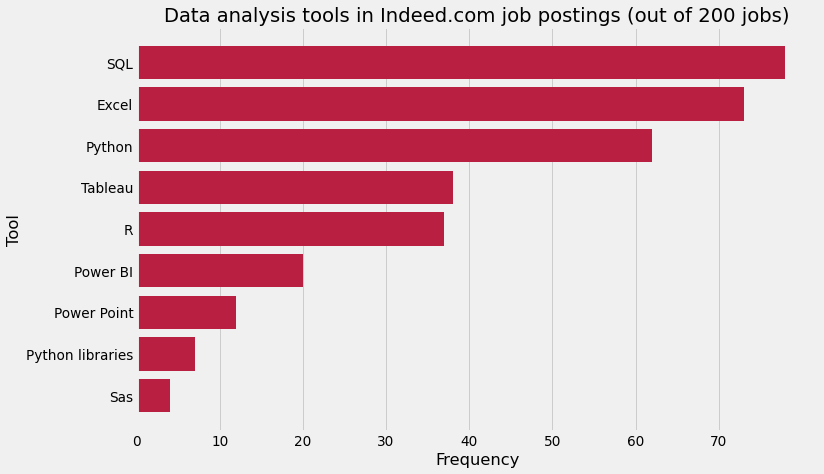

In [11]:
most_popular = data_analyst.most_popular[::-1]
plt.figure(figsize=(12, 7), dpi=70)
plt.barh(y=most_popular.index, width=most_popular, color='#B81F40')
plt.title('Data analysis tools in Indeed.com job postings (out of 200 jobs)')
plt.xlabel('Frequency')
plt.ylabel('Tool')
plt.xticks(range(0, most_popular.max(), 10))
plt.grid(visible=False, axis='y')
plt.style.use('fivethirtyeight')
plt.tight_layout()

**Remark**: The *Python libraries* section includes Pandas, NumPy and Matplotlib.

As seen above, the most sought-after tools in data analysis jobs are **SQL** (*78/200*), **Excel** (*73/200*) and **Python** (*62/100*).